# EE782 Assignment 2
# Bhuvana Chandra Pullabhotla
# 200070063

In [1]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)#mount google drive to get the the dataset

Mounted at /content/drive/


In [2]:
#Import the required libraries
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

#Initially loading the data and taking each persons folder by specifying the directory of each person and resize and normalize all the images

In [3]:
import os
from PIL import Image
import numpy as np

# Define a function to load image data from a specified directory
def load_data(data_directory):
    data = [] # Create an empty list to store image data
    datalabels = [] # Create an empty list to store corresponding labels

     # Get a list of subdirectories (each representing a person) in the specified data directory
    person_folders = os.listdir(data_directory)
    # Create a dictionary that maps labels (indices) to person names
    label_to_person = {i: person for i, person in enumerate(person_folders)}
    # Iterate through each person's directory
    for label, person in enumerate(person_folders):
        person_folder = os.path.join(data_directory, person)
        # Iterate through each image file in the person's folder
        for image_file in os.listdir(person_folder):
            image_path = os.path.join(person_folder, image_file)

            image = Image.open(image_path)
            image = image.resize((128, 128))  # Resize the image to your desired size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

            data.append(image)
            datalabels.append(label)
    # Convert the 'data' and 'datalabels' lists to NumPy arrays and return them
    return np.array(data), np.array(datalabels)

# Load train, validation, and test data
train_data, train_datalabels = load_data('/content/drive/MyDrive/ee782_assignment2_200070063/data/train_data')
validation_data, validation_datalabels = load_data('/content/drive/MyDrive/ee782_assignment2_200070063/data/val_data')
test_data, test_datalabels = load_data('/content/drive/MyDrive/ee782_assignment2_200070063/data/test_data')


In [4]:
print(train_data.shape,test_data.shape,validation_data.shape)#printing train,val and test data as array

(2535, 128, 128, 3) (464, 128, 128, 3) (507, 128, 128, 3)


In [5]:
print(train_datalabels.shape,test_datalabels.shape,validation_datalabels.shape)#printing train,val and test datalabels as array

(2535,) (464,) (507,)



# Now creating labels by making pairs of images
If the images in the image pair is of same person(from same person folder) then label it 1 if it is of different person, label it 0

In [5]:
# Define a function to create pairs of images for Siamese network training
def create_pairs(x, train_datalabels):
    unique_labels = np.unique(train_datalabels)# Find unique labels (classes) in the training data
    digit_indices = [np.where(train_datalabels == label)[0] for label in unique_labels]# Create a list of indices for each class

    pairs = []# Initialize an empty list to store pairs of images
    labels = [] # Initialize an empty list to store corresponding labels

    num_classes = len(digit_indices)

    for d in range(num_classes):
        for i in range(len(digit_indices[d])):
           # Select a positive pair with images from the same class
            z1, z2 = digit_indices[d][i], digit_indices[d][(i + 1) % len(digit_indices[d])]#taking images from same class
            pairs += [[x[z1], x[z2]]]#pair both the images
            labels +=[1]# Label 1 indicates a positive pair

            inc = random.randrange(1, num_classes)#take random number between 0 and number of classes
            dn = (d + inc) % num_classes#taking another persons folder which is not same as the first person
            while dn == d:
              z1, z2 = digit_indices[d][i], digit_indices[d][(i + 1) % len(digit_indices[d])]#if dn=d , then the both images are of same class, so label 1
              pairs += [[x[z1], x[z2]]]
              labels +=[1]
            z1, z2 = digit_indices[d][i], digit_indices[dn][random.randrange(len(digit_indices[dn]))]#if dn!=d then the imagges are of different class, so label 0
            pairs += [[x[z1], x[z2]]]

            labels += [0]

    return np.array(pairs), np.array(labels, dtype=np.float32)

#creating train, val and test pairs and corresponding labels
train_pairs, train_labels = create_pairs(train_data, train_datalabels)
val_pairs, val_labels = create_pairs(validation_data, validation_datalabels)
test_pairs, test_labels=create_pairs(test_data,test_datalabels)

In [20]:
test_pairs, test_labels=create_pairs(test_data,test_datalabels)

In [7]:
print(train_pairs.shape,test_pairs.shape,val_pairs.shape)#priniting train, val and test pairs shape

(5070, 2, 128, 128, 3) (928, 2, 128, 128, 3) (1014, 2, 128, 128, 3)


#  Definig a visulaize function to check the labels of image pairs

In [6]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """
    #https://keras.io/examples/vision/siamese_contrastive/
    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# Showing an example of visulaize function output

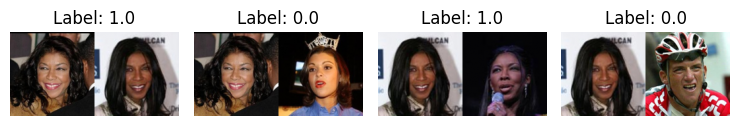

In [9]:
visualize(train_pairs[:-1], train_labels[:-1], to_show=4, num_col=4)

# Training the dataset on different models optimizers and taking two different learning rate schedulars and also training them using image augmentation

# learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# RMS prop optimizer with l2_strength and dropout added


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization

# Define a function to calculate Euclidean distance between vectors
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# Define a function to create the Siamese model
def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):

    # Define the input layer for the Siamese network with the given input shape
    input = layers.Input(input_shape)
    # Apply batch normalization to the input data
    x = tf.keras.layers.BatchNormalization()(input)
    # Apply a 2D convolutional layer with 4 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply 2D average pooling with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Apply another 2D convolutional layer with 16 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply another 2D average pooling layer with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Flatten the output of the previous layers
    x = layers.Flatten()(x)
    # Apply batch normalization to the flattened output
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a dense (fully connected) layer with 10 units, 'tanh' activation, and L2 regularization
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Create an embedding network using the defined layers
    embedding_network = keras.Model(input, x)
    # Define the input layers for the two input images
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)
    # Pass the input images through the shared embedding network
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    # Calculate the Euclidean distance between the embeddings of the two input images
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    # Apply batch normalization to the distance
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    # Create the Siamese model with inputs and outputs defined
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss
    # Compile the Siamese model with the specified loss function and optimizer
    siamese.compile(loss=loss(margin=margin), optimizer=RMSprop(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Train the Siamese model with learning rate schedule 1
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    epochs=epochs,
    batch_size=batch_size
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [21]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 12s 417ms/step - loss: 0.4090 - accuracy: 0.7047
Test Loss: 0.40904417634010315, Test Accuracy: 0.704741358757019


29/29 [==============================] - 9s 290ms/step


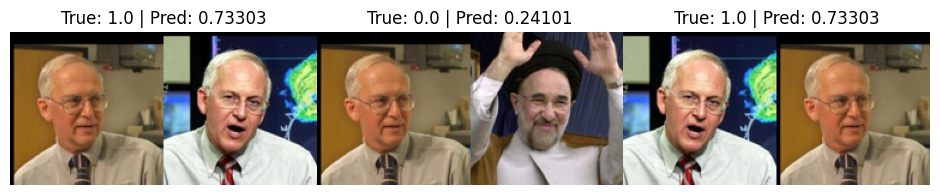

In [22]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

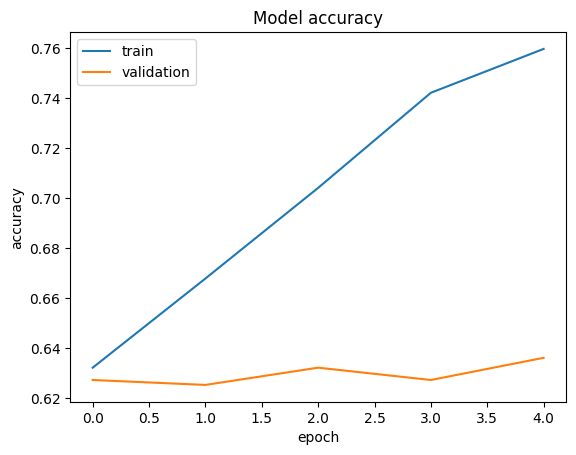

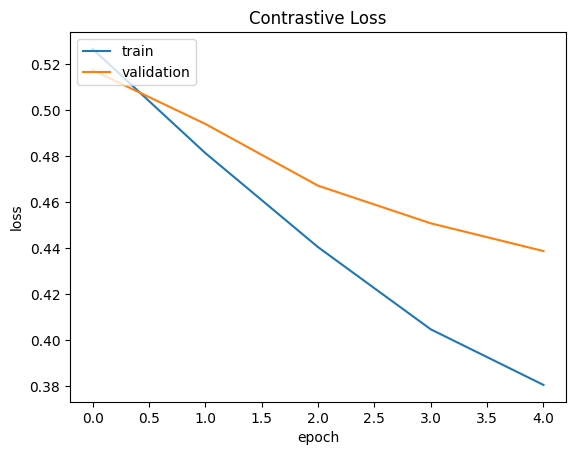

In [23]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Adam optimizer l2_strength and dropout added

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):

    # Define the input layer for the Siamese network with the given input shape
    input = layers.Input(input_shape)
    # Apply batch normalization to the input data
    x = tf.keras.layers.BatchNormalization()(input)
    # Apply a 2D convolutional layer with 4 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply 2D average pooling with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Apply another 2D convolutional layer with 16 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply another 2D average pooling layer with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Flatten the output of the previous layers
    x = layers.Flatten()(x)
    # Apply batch normalization to the flattened output
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a dense (fully connected) layer with 10 units, 'tanh' activation, and L2 regularization
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Create an embedding network using the defined layers
    embedding_network = keras.Model(input, x)
    # Define the input layers for the two input images
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)
    # Pass the input images through the shared embedding network
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    # Calculate the Euclidean distance between the embeddings of the two input images
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    # Apply batch normalization to the distance
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    # Create the Siamese model with inputs and outputs defined
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    siamese.compile(loss=loss(margin=margin), optimizer=Adam(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Train the Siamese model with learning rate schedule 1
history= siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    epochs=epochs,
    batch_size=batch_size
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [10]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 16s 541ms/step - loss: 0.3984 - accuracy: 0.6735
Test Loss: 0.39837926626205444, Test Accuracy: 0.673491358757019


29/29 [==============================] - 11s 376ms/step


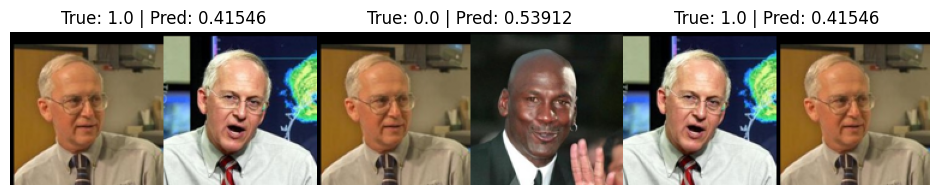

In [11]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

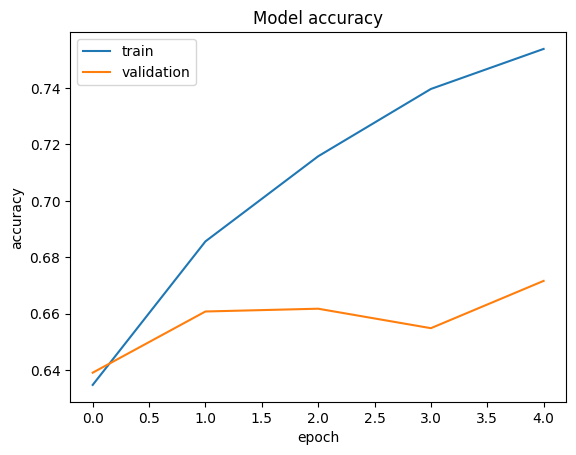

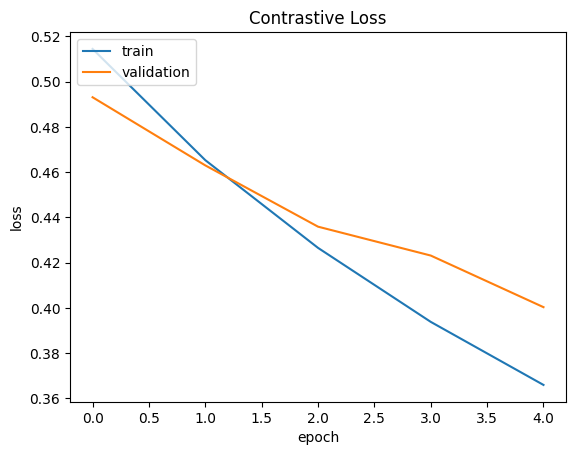

In [12]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# RMS prop optimizer l2_strength and dropout added including data augmentation

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):

    # Define the input layer for the Siamese network with the given input shape
    input = layers.Input(input_shape)
    # Apply batch normalization to the input data
    x = tf.keras.layers.BatchNormalization()(input)
    # Apply a 2D convolutional layer with 4 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply 2D average pooling with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Apply another 2D convolutional layer with 16 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply another 2D average pooling layer with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Flatten the output of the previous layers
    x = layers.Flatten()(x)
    # Apply batch normalization to the flattened output
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a dense (fully connected) layer with 10 units, 'tanh' activation, and L2 regularization
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Create an embedding network using the defined layers
    embedding_network = keras.Model(input, x)
    # Define the input layers for the two input images
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)
    # Pass the input images through the shared embedding network
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    # Calculate the Euclidean distance between the embeddings of the two input images
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    # Apply batch normalization to the distance
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    # Create the Siamese model with inputs and outputs defined
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    siamese.compile(loss=loss(margin=margin), optimizer=RMSprop(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule2 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule2),
    metrics=["accuracy"]
)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Custom data generator function
def data_generator(pairs, labels, batch_size):
    while True:
        indexes = np.arange(len(pairs))
        np.random.shuffle(indexes)
        for i in range(0, len(indexes), batch_size):
            batch_indexes = indexes[i:i + batch_size]
            batch_pairs = pairs[batch_indexes]
            batch_labels = labels[batch_indexes]
            augmented_batch = []
            for pair in batch_pairs:
                augmented_pair = [datagen.random_transform(image) for image in pair]
                augmented_batch.append(augmented_pair)
            yield [np.array(augmented_batch)[:, 0], np.array(augmented_batch)[:, 1]], batch_labels

# Create data generators
train_data_generator = data_generator(train_pairs, train_labels, batch_size)
val_data_generator = data_generator(val_pairs, val_labels, batch_size)

# Train the Siamese model
history = siamese_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_pairs) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_pairs) // batch_size,
    epochs=epochs
)




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [11]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 8s 283ms/step - loss: 0.4369 - accuracy: 0.4871
Test Loss: 0.43688273429870605, Test Accuracy: 0.48706895112991333


29/29 [==============================] - 11s 352ms/step


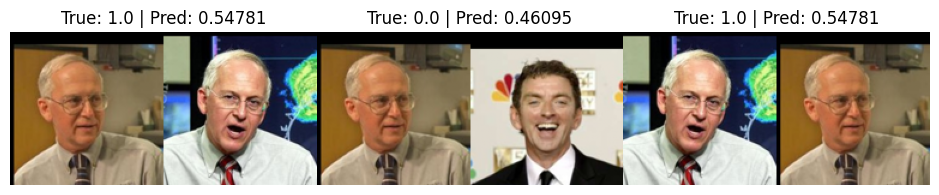

In [12]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

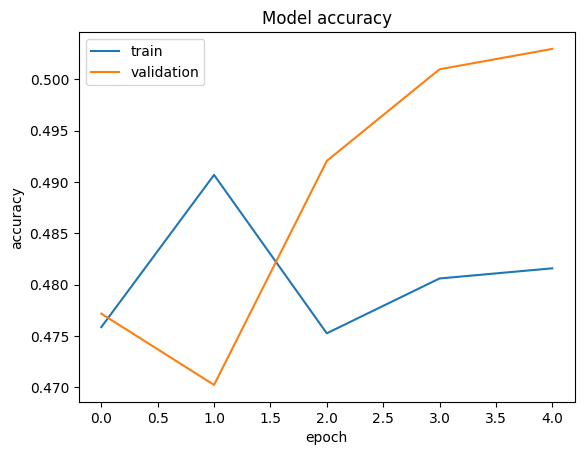

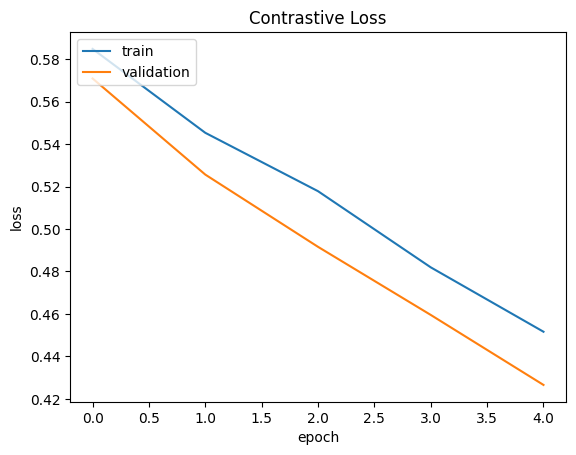

In [13]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Adam optimizer l2_strength and dropout added including data augmentation

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):

    # Define the input layer for the Siamese network with the given input shape
    input = layers.Input(input_shape)
    # Apply batch normalization to the input data
    x = tf.keras.layers.BatchNormalization()(input)
    # Apply a 2D convolutional layer with 4 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply 2D average pooling with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Apply another 2D convolutional layer with 16 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply another 2D average pooling layer with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Flatten the output of the previous layers
    x = layers.Flatten()(x)
    # Apply batch normalization to the flattened output
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a dense (fully connected) layer with 10 units, 'tanh' activation, and L2 regularization
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Create an embedding network using the defined layers
    embedding_network = keras.Model(input, x)
    # Define the input layers for the two input images
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)
    # Pass the input images through the shared embedding network
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    # Calculate the Euclidean distance between the embeddings of the two input images
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    # Apply batch normalization to the distance
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    # Create the Siamese model with inputs and outputs defined
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    siamese.compile(loss=loss(margin=margin), optimizer=Adam(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Custom data generator function
def data_generator(pairs, labels, batch_size):
    while True:
        indexes = np.arange(len(pairs))
        np.random.shuffle(indexes)
        for i in range(0, len(indexes), batch_size):
            batch_indexes = indexes[i:i + batch_size]
            batch_pairs = pairs[batch_indexes]
            batch_labels = labels[batch_indexes]
            augmented_batch = []
            for pair in batch_pairs:
                augmented_pair = [datagen.random_transform(image) for image in pair]
                augmented_batch.append(augmented_pair)
            yield [np.array(augmented_batch)[:, 0], np.array(augmented_batch)[:, 1]], batch_labels

# Create data generators
train_data_generator = data_generator(train_pairs, train_labels, batch_size)
val_data_generator = data_generator(val_pairs, val_labels, batch_size)

# Train the Siamese model
history = siamese_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_pairs) // batch_size,
    validation_data=val_data_generator,
    validation_steps=len(val_pairs) // batch_size,
    epochs=epochs
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 11s 362ms/step - loss: 0.4668 - accuracy: 0.4407
Test Loss: 0.466831773519516, Test Accuracy: 0.4407327473163605


29/29 [==============================] - 9s 283ms/step


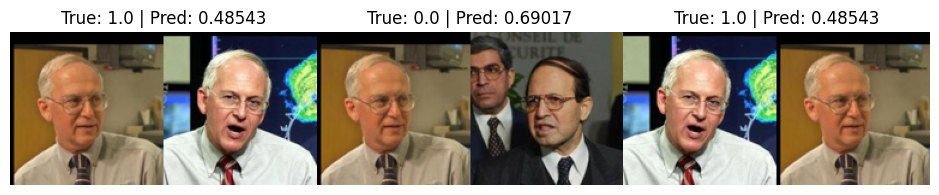

In [10]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

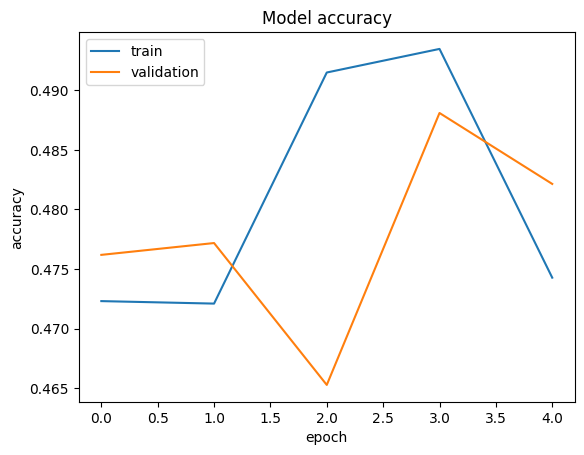

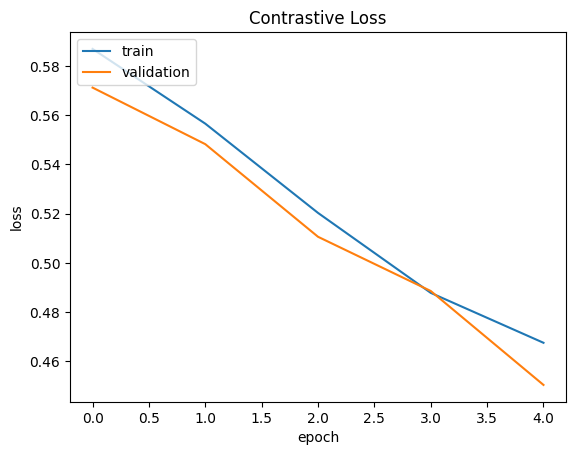

In [11]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# learning schedule =(initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9)

# RMS prop optimizer l2_strength and dropout added


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):
    input = layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(input)
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    embedding_network = keras.Model(input, x)

    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    siamese.compile(loss=loss(margin=margin), optimizer=RMSprop(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Train the Siamese model with learning rate schedule 1
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    epochs=epochs,
    batch_size=batch_size
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [7]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 9s 294ms/step - loss: 0.2729 - accuracy: 0.5560
Test Loss: 0.2729347348213196, Test Accuracy: 0.556034505367279


29/29 [==============================] - 11s 369ms/step


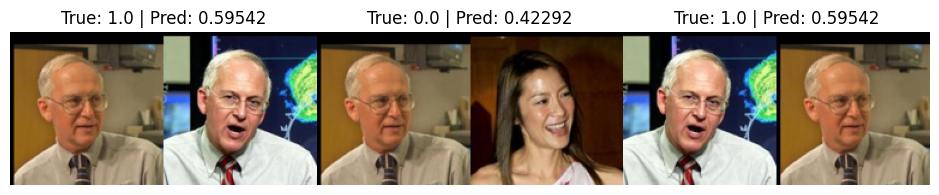

In [8]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

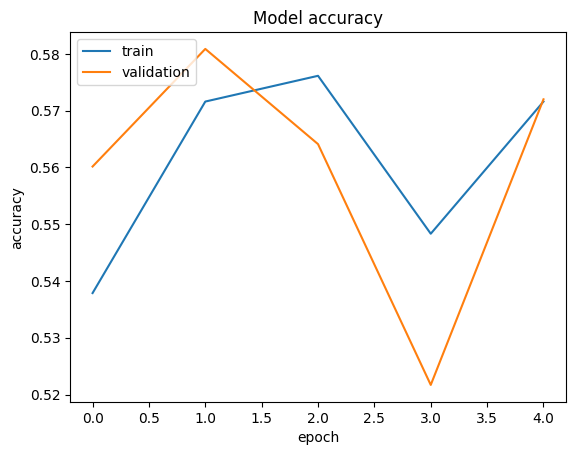

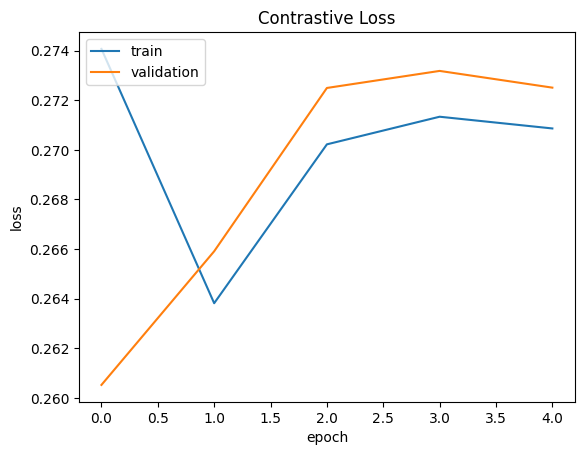

In [9]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# learning schedule =(initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9)

# Adam prop optimizer l2_strength and dropout added(RUN THIS)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Hyperparameters
epochs = 5
batch_size = 16
margin = 1
dropout_rate = 0.2
l2_strength = 0.01

# Create the Siamese model with dropout and L2 regularization
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_model(input_shape, dropout_rate=0.2, margin=1, l2_strength=0.01):

    # Define the input layer for the Siamese network with the given input shape
    input = layers.Input(input_shape)
    # Apply batch normalization to the input data
    x = tf.keras.layers.BatchNormalization()(input)
    # Apply a 2D convolutional layer with 4 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(4, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply 2D average pooling with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Apply another 2D convolutional layer with 16 filters, a 5x5 kernel, 'tanh' activation, and L2 regularization
    x = layers.Conv2D(16, (5, 5), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Apply another 2D average pooling layer with a pool size of (2, 2)
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    # Flatten the output of the previous layers
    x = layers.Flatten()(x)
    # Apply batch normalization to the flattened output
    x = tf.keras.layers.BatchNormalization()(x)
    # Apply a dense (fully connected) layer with 10 units, 'tanh' activation, and L2 regularization
    x = layers.Dense(10, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    # Create an embedding network using the defined layers
    embedding_network = keras.Model(input, x)
    # Define the input layers for the two input images
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)
    # Pass the input images through the shared embedding network
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    # Calculate the Euclidean distance between the embeddings of the two input images
    merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
    # Apply batch normalization to the distance
    normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
    # Create the final output layer with sigmoid activation
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    # Create the Siamese model with inputs and outputs defined
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    def loss(margin=margin):
        def contrastive_loss(y_true, y_pred):
            square_pred = tf.math.square(y_pred)
            margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
            return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

        return contrastive_loss

    siamese.compile(loss=loss(margin=margin), optimizer=Adam(), metrics=["accuracy"])

    return siamese


# Create the Siamese model with dropout, L2 regularization, and specify margin
siamese_model = create_siamese_model((128,128, 3), dropout_rate, margin, l2_strength)
siamese_model.summary()

# Define learning rate schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9)

# Compile the Siamese model with the chosen learning rate schedule
siamese_model.compile(
    loss=siamese_model.loss,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Train the Siamese model with learning rate schedule 1
history = siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    epochs=epochs,
    batch_size=batch_size
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 10)           190326      ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [7]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29/29 [==============================] - 13s 430ms/step - loss: 0.2991 - accuracy: 0.5905
Test Loss: 0.29911211133003235, Test Accuracy: 0.5905172228813171


29/29 [==============================] - 12s 385ms/step


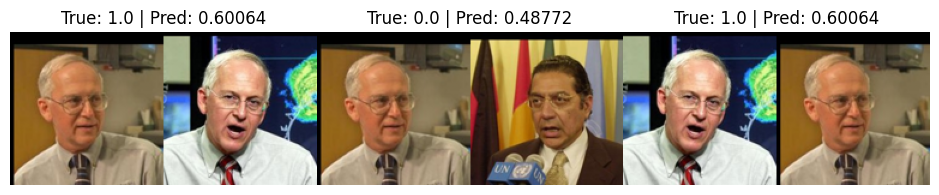

In [8]:
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
visualize(test_pairs,test_labels, to_show=3, predictions=predictions, test=True)

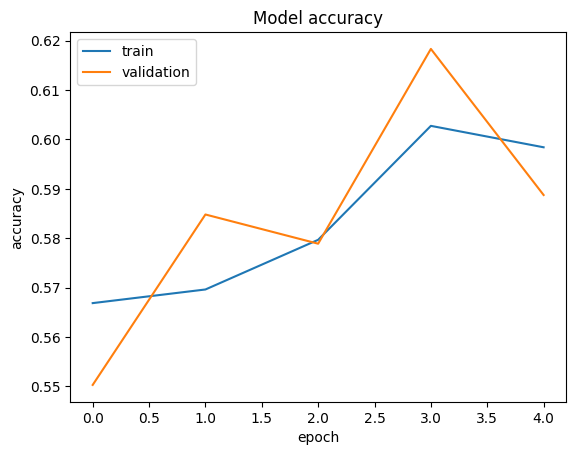

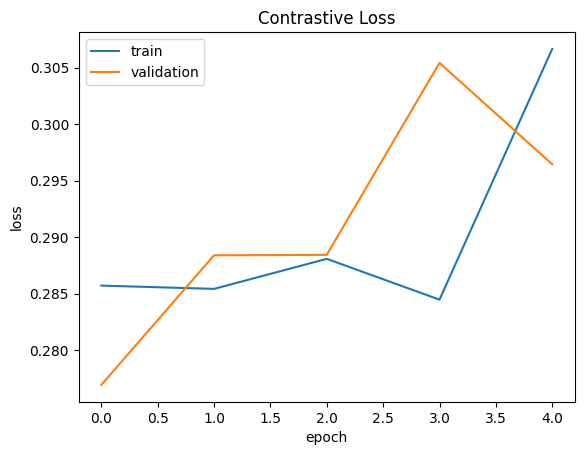

In [9]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

#https://keras.io/examples/vision/siamese_contrastive/

# Observations
learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9) give more accuracy and low loss than learning schedule =(initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9), because

-  A smaller initial learning rate (0.0001 ) allows the optimization process to start with smaller steps

- With more frequent decay steps (1000 ), the learning rate decreases at a faster rate. This means that the learning rate adapts to the training process more dynamically.

And with same learning schedule schemes, RMSprop optimizer worked slightly better than Adam optimizer even thought the difference in ccuracy is very less, but when image augmentation is also included, both optimizers worked almost similarly

# Testing on images of mine and my friends

- I have used learning schedule =(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9)
RMS prop optimizer with l2_strength and dropout added siemese model as it gave the highest accuracy of all the methods

In [15]:
test_data_new, test_datalabels_new = load_data('/content/drive/MyDrive/ee782_assignment2_200070063/assgn2_friends_photos')

In [16]:
test_pairs_new, test_labels_new=create_pairs(test_data_new,test_datalabels_new)

In [17]:
test_data_new.shape

(10, 128, 128, 3)

In [18]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate([test_pairs_new[:, 0], test_pairs_new[:, 1]], test_labels_new)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

1/1 [==============================] - 0s 269ms/step - loss: 0.4337 - accuracy: 0.5500
Test Loss: 0.43367981910705566, Test Accuracy: 0.550000011920929


1/1 [==============================] - 1s 552ms/step


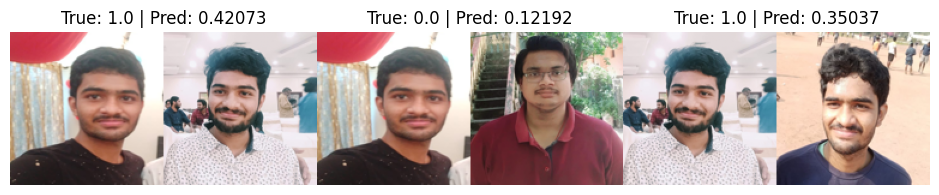

In [19]:
predictions = siamese_model.predict([test_pairs_new[:, 0], test_pairs_new[:, 1]])
visualize(test_pairs_new,test_labels_new, to_show=3, predictions=predictions, test=True)

# Question 2

Train a generative model for generating face images, using a GAN. The generator takes a
Gaussian noise vector as input, and tries to output a face image, while the discriminator
distinguishes between real and fake face images.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LeakyReLU, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# Define the dimensions
noise_dim = 100  # Dimensionality of the random noise vector
image_dim = (28, 28, 1)  # Dimensions of the generated images (28x28 pixels, 1 channel for grayscale)

# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=noise_dim))  # Input layer with noise_dim neurons, accepts random noise
    model.add(LeakyReLU(0.2))  # Activation function (Leaky ReLU)
    model.add(Dense(512))  # Hidden layer
    model.add(LeakyReLU(0.2))
    model.add(Dense(1024))  # Hidden layer
    model.add(LeakyReLU(0.2))
    model.add(Dense(np.prod(image_dim), activation='tanh'))  # Output layer produces image data (-1 to 1 range)
    model.add(Reshape(image_dim))  # Reshape output to match image_dim
    return model

# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=image_dim))  # Flatten input image for processing
    model.add(Dense(1024))  # Hidden layer
    model.add(LeakyReLU(0.2))  # Activation function (Leaky ReLU)
    model.add(Dense(512))  # Hidden layer
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))  # Hidden layer
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer classifies real or fake
    return model

# Create the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['accuracy'])
# Compile the discriminator model with binary cross-entropy loss for binary classification (real or fake)

# Create a GAN model by combining the generator and discriminator
discriminator.trainable = False  # Freeze discriminator's weights during GAN training
gan_input = Input(shape=(noise_dim,))  # Define the input for the GAN, which is a noise vector
x = generator(gan_input)  # Generate fake images using the generator
gan_output = discriminator(x)  # Use the discriminator to classify the generated images
gan = Model(gan_input, gan_output)  # Combine generator and discriminator into a GAN model
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
# Compile the GAN model with binary cross-entropy loss for generator training

# Load and preprocess a smaller subset of the MNIST dataset
(real_images, _), (_, _) = mnist.load_data()  # Load the MNIST dataset
real_images = real_images / 127.5 - 1.0  # Normalize pixel values to the range [-1, 1]
real_images = np.expand_dims(real_images, axis=-1)  # Add a channel dimension to match image_dim

# Reduce the dataset size
num_samples = 3000  # Define the number of samples to use for training
real_images = real_images[:num_samples]  # Use a subset of the MNIST dataset

# Training the GAN
batch_size = 64  # Define the batch size for training
epochs = 25  # Reduced number of training epochs for faster execution

for epoch in range(epochs):
    for _ in range(len(real_images) // batch_size):
        noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate random noise
        generated_images = generator.predict(noise)  # Generate fake images using the generator
        real_batch = real_images[np.random.randint(0, len(real_images), batch_size)]  # Sample real images

        # Create labels for real and fake images
        labels_real = np.ones((batch_size, 1))  # Label for real images is 1 (real)
        labels_fake = np.zeros((batch_size, 1))  # Label for fake images is 0 (fake)

        # Train the discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_batch, labels_real)  # Train discriminator on real images
        d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)  # Train discriminator on fake images
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Combine losses for real and fake

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate random noise
        labels_gan = np.ones((batch_size, 1))  # Labels for generator's loss are 1 (real)
        g_loss = gan.train_on_batch(noise, labels_gan)  # Train the generator

    # Print the progress
    print(f"Epoch {epoch}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


#Took help of chatgpt to build the generator and discriminator model


2/2 [==============================] - 0s 7ms/step
Epoch 0/25, D Loss: 0.02079214178957045, G Loss: 4.879391670227051
2/2 [==============================] - 0s 7ms/step
Epoch 1/25, D Loss: 1.315218597650528, G Loss: 0.305403470993042
2/2 [==============================] - 0s 8ms/step
Epoch 2/25, D Loss: 0.011210235785256373, G Loss: 4.586169242858887
2/2 [==============================] - 0s 6ms/step
Epoch 3/25, D Loss: 0.04506328725256026, G Loss: 5.373022079467773
2/2 [==============================] - 0s 7ms/step
Epoch 4/25, D Loss: 0.26732972264289856, G Loss: 5.57036018371582
2/2 [==============================] - 0s 6ms/step
Epoch 5/25, D Loss: 0.12105507892556489, G Loss: 5.398972511291504
2/2 [==============================] - 0s 6ms/step
Epoch 6/25, D Loss: 0.03137073293328285, G Loss: 5.705753326416016
2/2 [==============================] - 0s 7ms/step
Epoch 7/25, D Loss: 0.020552530884742737, G Loss: 5.648243427276611
2/2 [==============================] - 0s 9ms/step
Epoch 

Video Link - https://drive.google.com/file/d/1hJcqIIOfFVeGTxPa7hGbJk0FwdtW-pU3/view?usp=share_link

I have given the reference links in the code where I have used them itself